# Simple network embeddings demonstration
In this short demo, we demonstrate how the simple embeddings can work with the use of:
*   Node2Vec (making embeddings)
*   t-SNE (dimensions reduction) 


# Before running the code

Make sure you have uploaded **as-rank.caida.peercones-with-IX-short.txt** file to the colab workspace (*content* directory) from our github repo. 

In [1]:
%%capture
!pip install node2vec

In [2]:
!pwd
# in content directory upload file "as-rank.caida.peercones-with-IX-short.txt"

/content


# Visualizing input data

Visualizing input data might be interesting to see similarities (neighborhood, degree of nodes) in the input data

NOTE that the distances between nodes are randomized. 

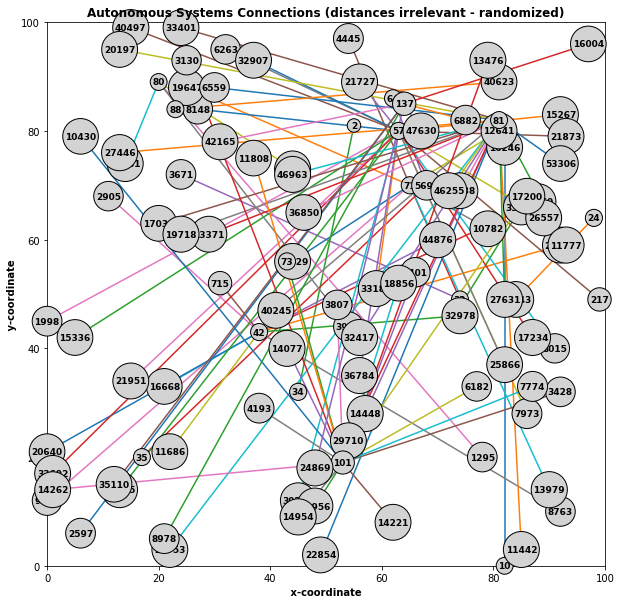

In [5]:
# Connections plotting
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import random 
EMBEDDING_FILENAME="em_filename.txt"
EMBEDDING_MODEL_FILENAME="em_model"
EDGES_EMBEDDING_FILENAME="edg_em_file"

# graph = nx.fast_gnp_random_graph(n=10, p=0.5)
as_relation_file=open("as-rank.caida.peercones-with-IX-short.txt",'r')

plt.figure(figsize=(10,10))
plt.xlim(0,100)
plt.ylim(0,100)

node_list = {}

graph = nx.Graph()
for line in as_relation_file:
     if line.startswith('#'):
         continue
     w = line.split('|')
     
     #graph.add_node(w[0], w[1])
     graph.add_edge(w[0], w[1])

# randomizing AS locations in map
for i in graph.nodes:
  x_random = random.randint(0,100)
  y_random = random.randint(0,100)
  node_list[i]= ([x_random,y_random])  
  plt.text(x_random,y_random,str(i),fontdict={'weight': 'bold', 'size': 9},ha="center", va="center",bbox = dict(boxstyle=f"circle,pad={0.25}", fc="lightgrey"))

# Looking for edges
for j in graph.edges:
  plt.plot([node_list[j[0]][0],node_list[j[1]][0]],[node_list[j[0]][1],node_list[j[1]][1]])

plt.title('Autonomous Systems Connections (distances irrelevant - randomized)',fontweight="bold")

print()
print()

plt.xlabel(' x-coordinate ',fontweight="bold")
plt.ylabel(' y-coordinate ', fontweight="bold")
plt.show()

# Node2Vec
*  Node2Vec is an algorithm to generate vector representations of nodes on a graph.
*  This framework learns low-dimensional representations for nodes in a graph through the use of random walks
*  The algorithm is considered as one of the best graph classifiers.
## Input Data
The algorithm takes real-world Autonomous System connections as an input to the program
## Output Data
Every node (vel Autonomous System) is represented as multi-demensional vector that is preserving structural similarities from input graph

In [6]:
# Node2Vec
 
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
#edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
#edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

Computing transition probabilities:   0%|          | 0/111 [00:00<?, ?it/s]

Generating edge features: 100%|██████████| 6216/6216.0 [00:00<00:00, 85864.44it/s]


# Visualizing Output Data 
*   To visualize how the output data is looking, you can uncomment below line to see the whole file that is containing node's id and their vector representation
*  To see it more clearly, we use t-SNE algorithm to reduce the size of embeddings 

In [8]:
import sys
print(sys.version)
# !cat em_filename.txt

# Algorytm t-SNE
*   Algorithm belonging to the manifold learning class
*   The idea is to find a two-dimensional representation of your data that best preserves the distances between the points
*   Starts with a random two-dimensional representation for each data point and then tries to approximate points that are close to the original feature space and points that are far apart in the original feature space are far apart




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConversionWarning: Some errors were detected !
    Line #1 (got 2 columns instead of 64)
  """


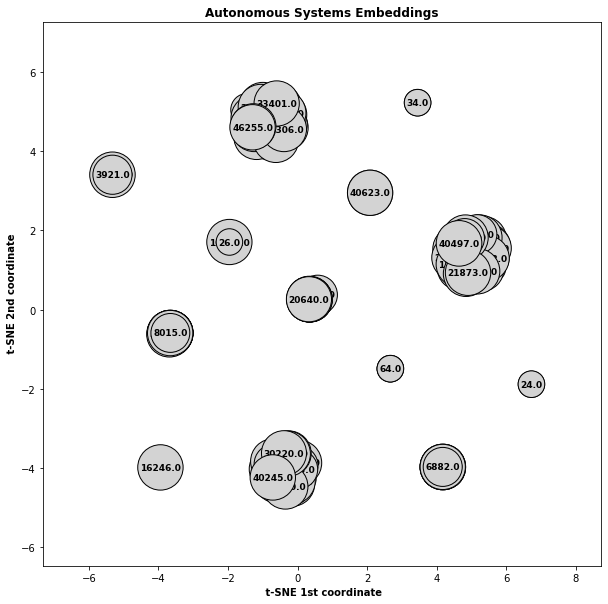

In [10]:
import numpy as np
from sklearn.manifold import TSNE

# extracting data without id's
File_data = np.genfromtxt("em_filename.txt", dtype=float,invalid_raise = False,usecols=np.arange(1, 65))

# extracting id's from source file
as_labels = np.genfromtxt("em_filename.txt", dtype=float,invalid_raise = False,usecols=np.arange(0, 1))

# making embeddings 
embedding = TSNE(n_components=2,learning_rate='auto',init='random').fit_transform(File_data)

# plot limiting
plt.figure(figsize=(10,10))
plt.xlim(embedding[:,0].min()-2,embedding[:,0].max() + 2)
plt.ylim(embedding[:,1].min()-2,embedding[:,1].max() + 2)

# assigning numbers to points in plot 
for i in range(len(embedding)):
  plt.text(embedding[i,0],embedding[i,1],str(as_labels[i]),fontdict={'weight': 'bold', 'size': 9},ha="center", va="center",bbox = dict(boxstyle=f"circle,pad={0.25}", fc="lightgrey"))

# plotting
plt.xlabel(' t-SNE 1st coordinate',fontweight="bold")
plt.ylabel(' t-SNE 2nd coordinate', fontweight="bold")
plt.title('Autonomous Systems Embeddings',fontweight="bold")
plt.show()
